In [1]:
# !pip install tqdm
# !pip install matplotlib
# !pip install seaborn

%load_ext autoreload

%autoreload 2

In [2]:
import sys
import os
#make the self written stuff findeable independent on who downloads it
#sts.path.append( ) makes the module importable
# os.path.dirname(os.getcwd()) provides the parent directory
sys.path.append(os.path.dirname(os.getcwd()))

In [3]:
import os
 
dirpath = os.getcwd()
print("current directory is : " + dirpath)
foldername = os.path.basename(dirpath)
print("Directory name is : " + foldername)


current directory is : C:\Users\Utis\Documents\GitHub\tensorflow_1.X_playground\regression\notebooks
Directory name is : notebooks


In [4]:
from data.generators import ToyDataset


In [5]:
from helpers import _TFColor, colors, lazy_property
import helpers
TFColor = _TFColor()

In [6]:
import numpy as np

import matplotlib.pyplot as plt

matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res

In [7]:
figsize(20,7)

In [8]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
 
 
from tensorflow.python.platform import tf_logging as logging
 
logging.set_verbosity(logging.INFO)
logging.log(logging.INFO, "Tensorflow version " + tf.__version__)

INFO:tensorflow:Tensorflow version 1.13.1


In [9]:
tf.set_random_seed(42)


In [10]:
from data.generators import ToyDataset

In [12]:
DATA_SEQ_LEN = 50#300#240


dataset = ToyDataset(DATA_SEQ_LEN,DATA_SEQ_LEN)
X, y = dataset.X, dataset.y

In [13]:
gdef = dataset.graph()

Now the shufflebuffer includes the whole dataset and we have loads of randomness in the sequence to work with.

In [14]:
#https://stackoverflow.com/questions/33748552/tensorflow-how-to-replace-a-node-in-a-calculation-graph

In [15]:
from models.networks import DropoutNetwork
from models.ensembles import VanillaEnsemble, OnlineBootstrapEnsemble, UncertaintyModelEnsemble

In [16]:
meta_epochs = 20
plt.figure(figsize = (16,8*meta_epochs))

<Figure size 1152x11520 with 0 Axes>

<Figure size 1152x11520 with 0 Axes>

In [17]:
seeds = [1,2,3,4,5]
layers = [
    [10, 50, 20, 30, 10],
    [100, 50],
    [30, 30, 30],
    [5, 10, 100],
    [50, 50, 50]
]

In [18]:
estimator_stats = [{
            'ds_graph' : gdef,
            'num_neurons': num_neurons,
            'num_epochs': 10,
            'seed':seed,
    'activations': [tf.nn.tanh,tf.nn.tanh,tf.nn.tanh,tf.nn.tanh,tf.nn.relu]
    #activagtions:tf.nn.relu  #tf.nn.tanh
        } for seed, num_neurons in zip(seeds,layers)]

In [19]:
estimator_stats = [ 
    {'ds_graph': gdef,
    'num_epochs':10, 
    'keep_prob' : 0.8, 
    'num_neurons' : [50, 50, 50],
    'activations' : [tf.nn.relu,tf.nn.relu,tf.nn.tanh],  
    'seed': seed} for seed in [11,12,13,15,16] ]

In [20]:
#van = OnlineBootstrapEnsemble(gdef,num_epochs=10,estimator_stats=estimator_stats)
#van = VanillaEnsemble(gdef,num_epochs=10,estimator_stats=estimator_stats)
# van = DropoutNetwork(gdef,
#                      num_epochs=10, 
#                      keep_prob = 0.8, 
#                      num_neurons = [50, 50, 50],
#                      activations = [tf.nn.relu,tf.nn.relu,tf.nn.tanh],seed=11  )
van = UncertaintyModelEnsemble(gdef,num_epochs=10, estimator_stats=estimator_stats)




Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
initialising Network <class 'models.networks.DropoutNetwork'>
initialising Network <class 'models.networks.DropoutNetwork'>
initialising Network <class 'models.networks.DropoutNetwork'>
initialising Network <class 'models.networks.DropoutNetwork'>
initialising Network <class 'models.networks.DropoutNetwork'>


In [21]:
def get_mean_var(pred_dict):
    return pred_dict['means'],pred_dict['stds']

In [22]:
# len(van.estimator_list)

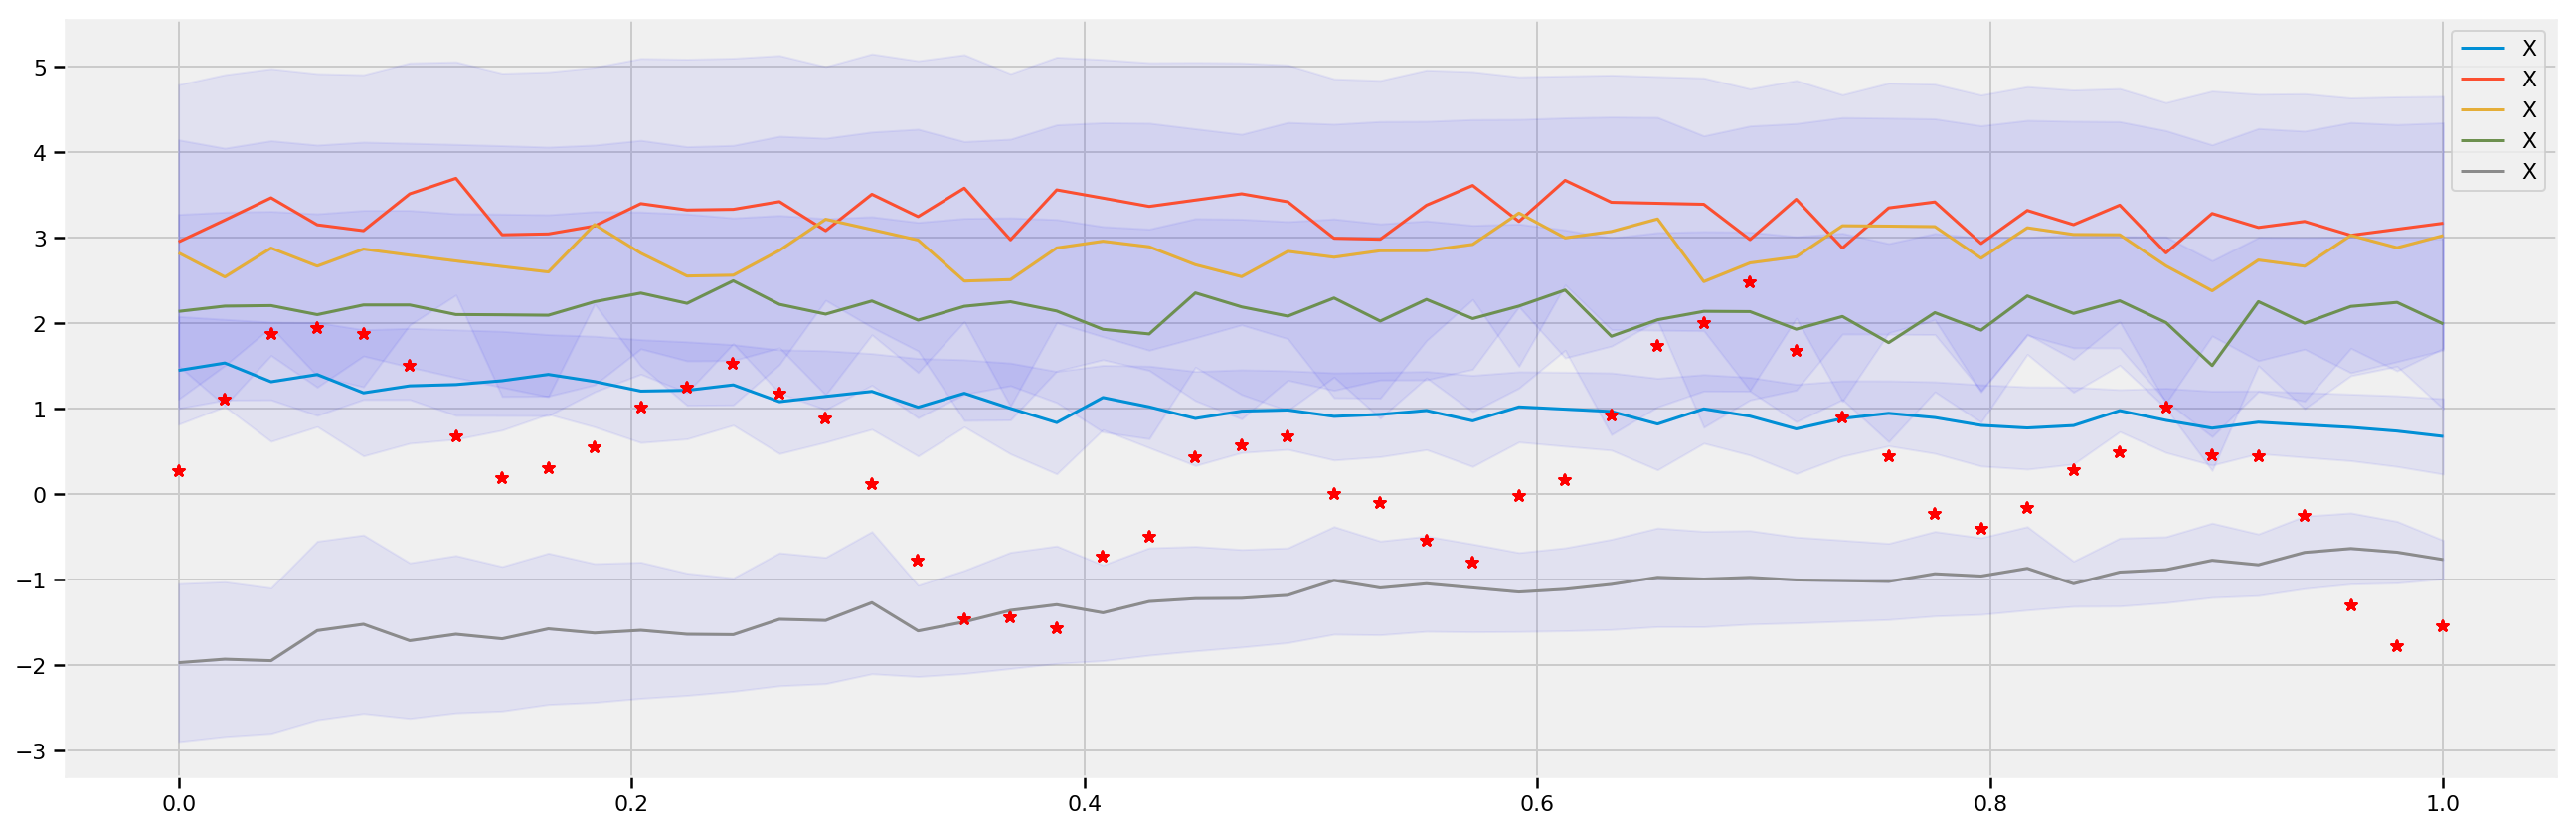

In [23]:

for i in range(len(estimator_stats)):
    mean, var = get_mean_var(van.estimator_list[i].predict(X))
    # mean = np.mean(mean,0)
    # var = np.mean(mean)

    plt.plot(X,mean,label='X')
    plt.plot(X,y,'r*')
    plt.fill_between(np.squeeze(X),np.squeeze(mean), np.squeeze(mean+var),alpha=0.3/len(estimator_stats), color='b')
    plt.fill_between(np.squeeze(X),np.squeeze(mean), np.squeeze(mean-var),alpha=0.3/len(estimator_stats), color='b')
    plt.legend()

In [24]:
# var

In [25]:
# var

In [26]:
#van.fit(1000)

In [27]:
# mean, var = get_mean_var(van.predict(X))

# plt.plot(X,mean,label='X')
# plt.plot(X,y,'r*')
# plt.fill_between(np.squeeze(X),np.squeeze(mean), np.squeeze(mean+var),alpha=0.3, color='b')
# plt.fill_between(np.squeeze(X),np.squeeze(mean), np.squeeze(mean-var),alpha=0.3, color='b')
# plt.legend()

In [28]:
# a = van.fit(100)

In [29]:
import tqdm

In [30]:
import numpy as np

import scipy 


def rmse(y_hat, y):
    return np.sqrt(np.mean((y_hat - y)**2))


def coverage_probability(prediction, variance, truth):
    CP = 0
    for y_hat, s, y in zip(prediction, variance, truth):
        if y_hat + s > y > y_hat - s:
            CP += 1

    #if (y - 2 * s < 0) and (y + 2 * s > 0):
    #    CP += 1
    return CP / len(truth)

def error_uncertainty_correlation(prediction,variance,truth):
    prediction, variance, truth = prediction.flatten(), variance.flatten(), truth.flatten()
    assert prediction.shape == truth.shape == variance.shape, 'shapes are: pred {} truth {} variance {}'.format(prediction.shape, truth.shape, variance.shape)
    error = (prediction - truth.flatten())**2
    correlation = scipy.stats.pearsonr(error.flatten(),variance.flatten())
    
    #np.correlate(error.flatten(),variance.flatten())
    return correlation

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

rsme is 1.622723937034607. 
 Coverage is 0.38. 
 COBEAU is (-0.29923505, 0.03476968968406932).


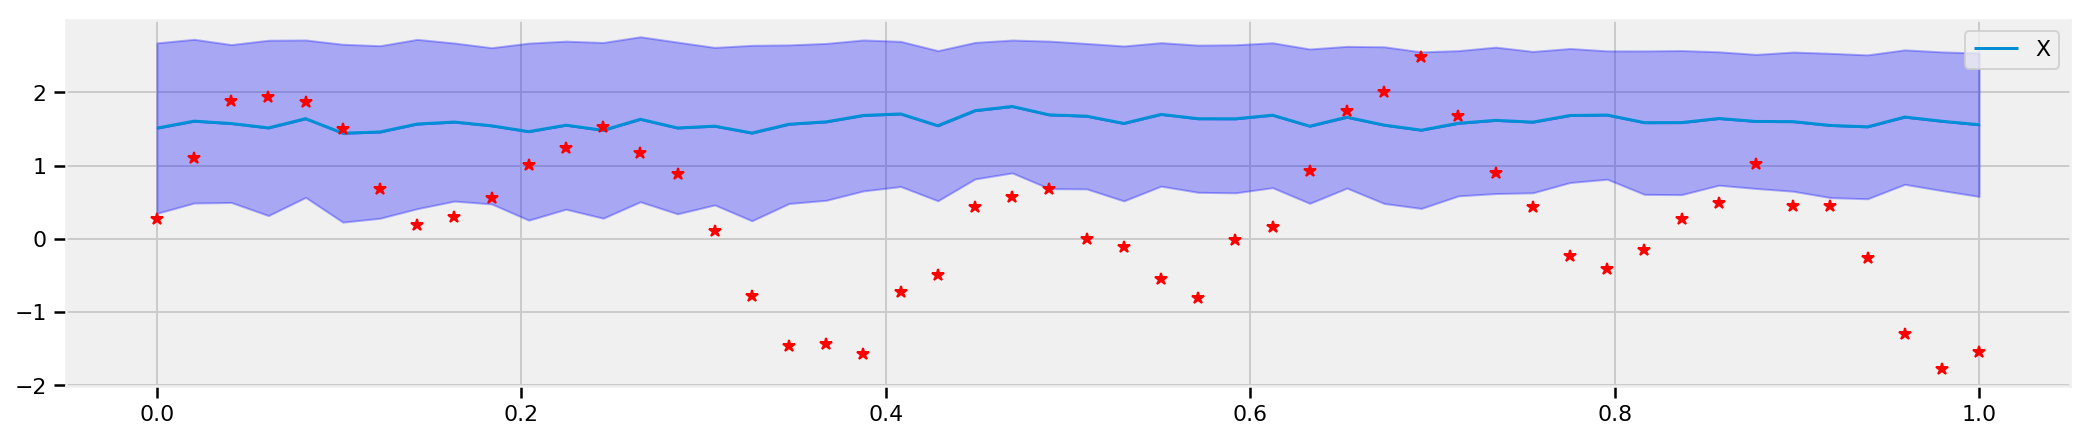

  5%|████▏                                                                              | 1/20 [00:08<02:42,  8.56s/it]

rsme is 1.1882715225219727. 
 Coverage is 0.26. 
 COBEAU is (0.20699374, 0.14921211557950792).


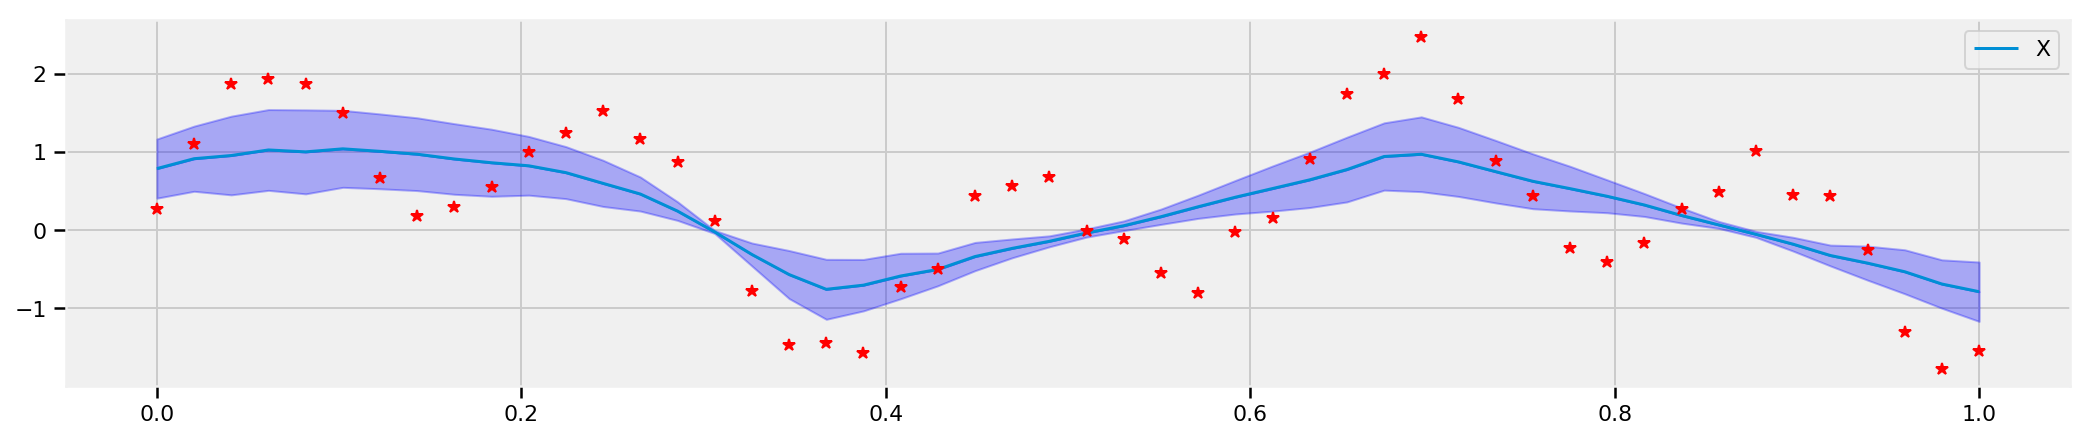

 10%|████████▎                                                                          | 2/20 [00:16<02:31,  8.39s/it]

rsme is 1.22187340259552. 
 Coverage is 0.26. 
 COBEAU is (0.12167363, 0.39993616609932914).


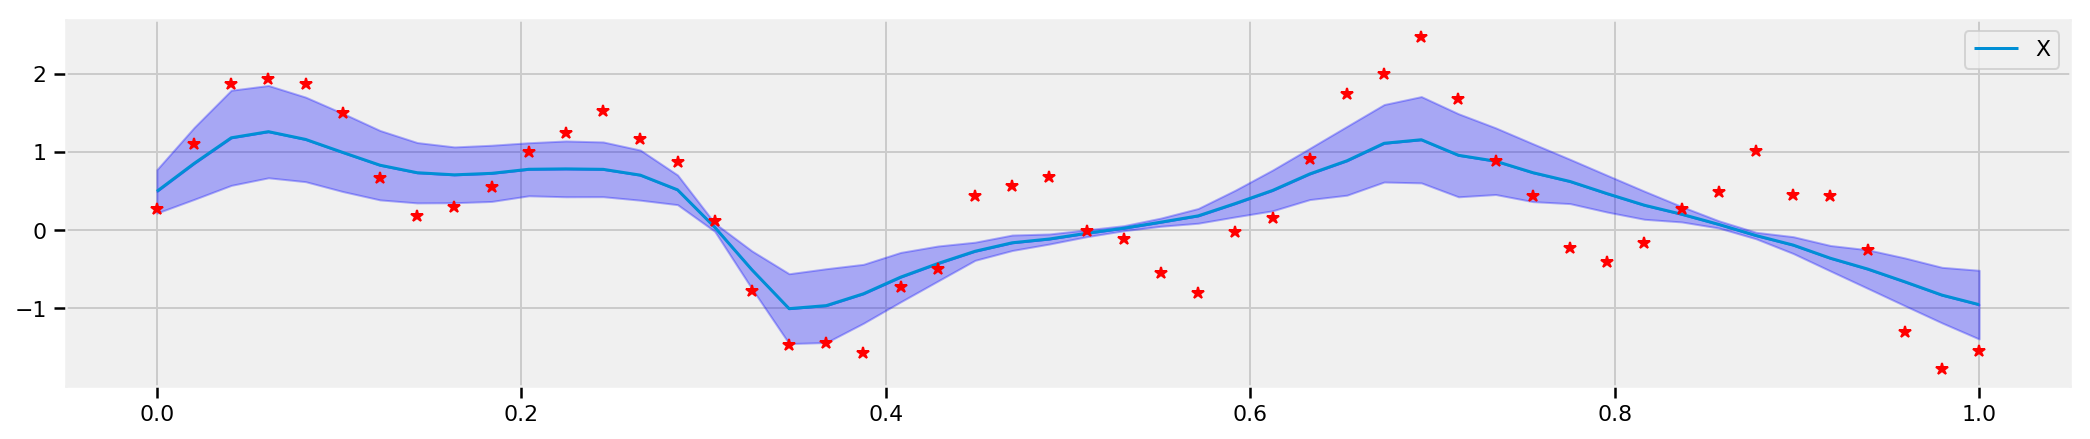

 15%|████████████▍                                                                      | 3/20 [00:24<02:20,  8.27s/it]

rsme is 1.2390687465667725. 
 Coverage is 0.46. 
 COBEAU is (0.13220216, 0.36009074693744436).


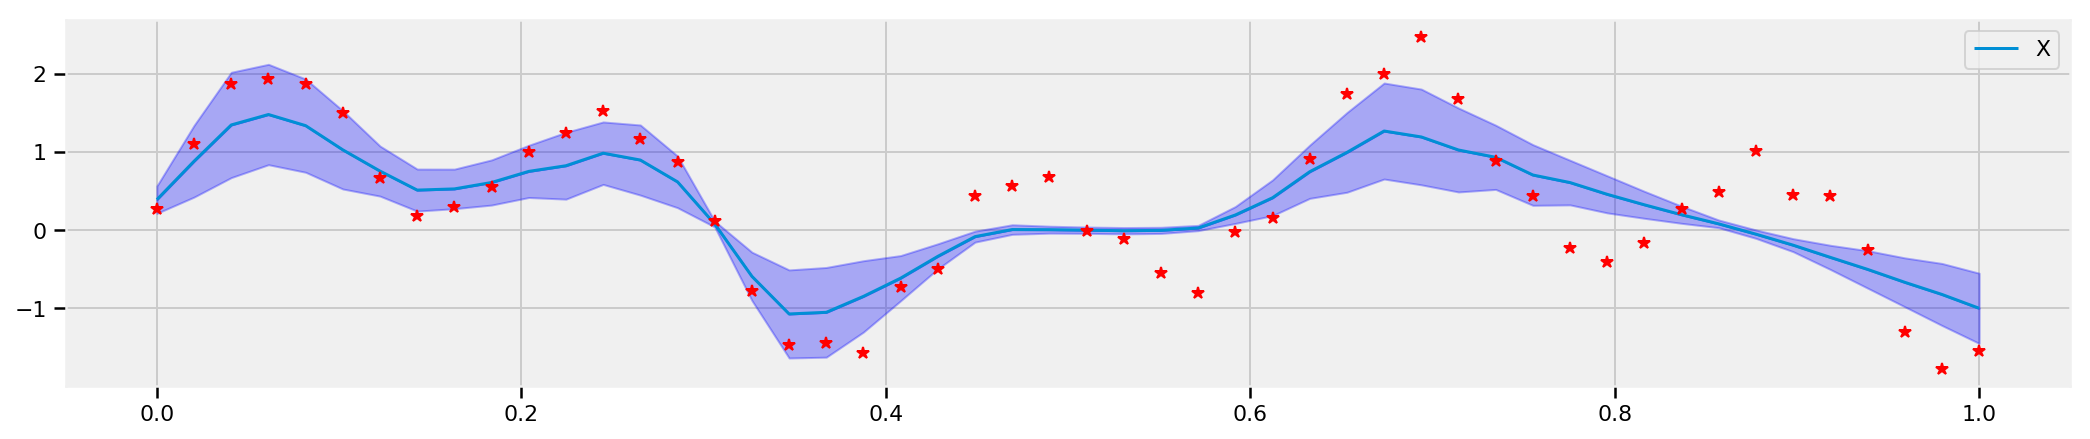

 20%|████████████████▌                                                                  | 4/20 [00:32<02:11,  8.22s/it]

rsme is 1.259921908378601. 
 Coverage is 0.54. 
 COBEAU is (0.10017315, 0.48883717512058833).


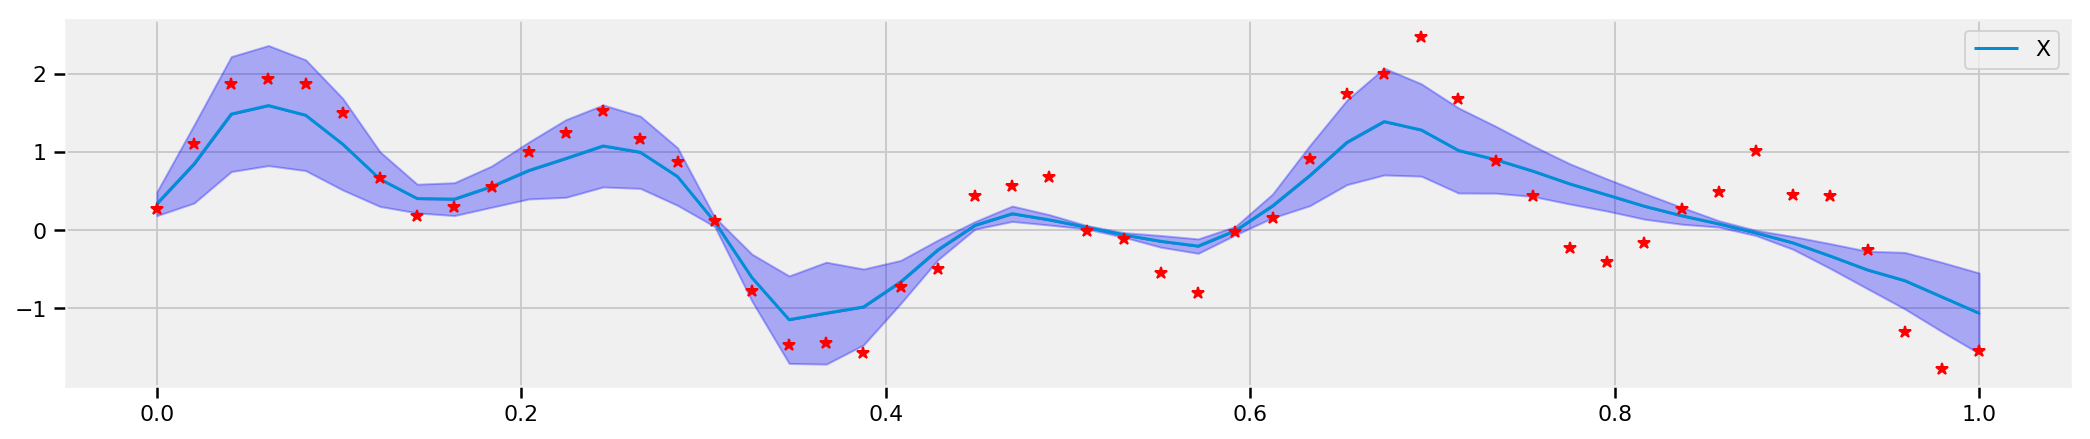

 25%|████████████████████▊                                                              | 5/20 [00:40<02:03,  8.24s/it]

rsme is 1.2707445621490479. 
 Coverage is 0.62. 
 COBEAU is (0.15963072, 0.2681516708887525).


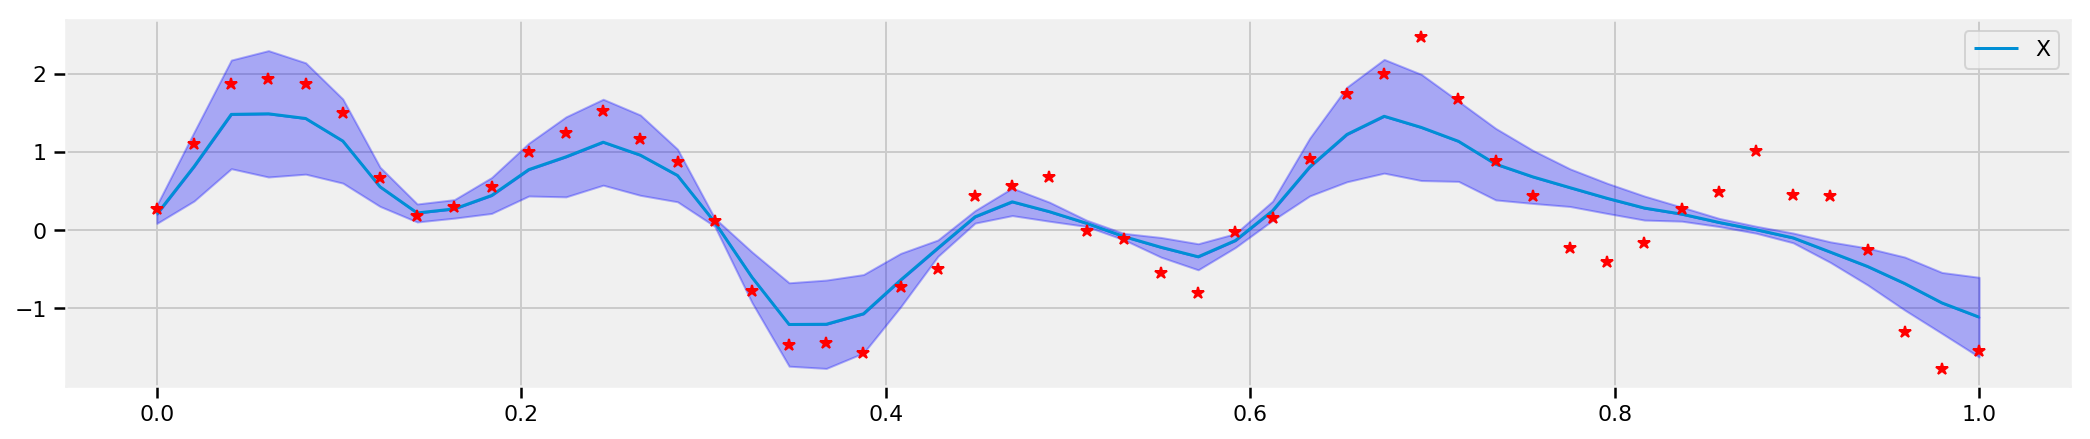

 30%|████████████████████████▉                                                          | 6/20 [00:48<01:54,  8.19s/it]

rsme is 1.2908596992492676. 
 Coverage is 0.64. 
 COBEAU is (0.12154639, 0.40043287149094775).


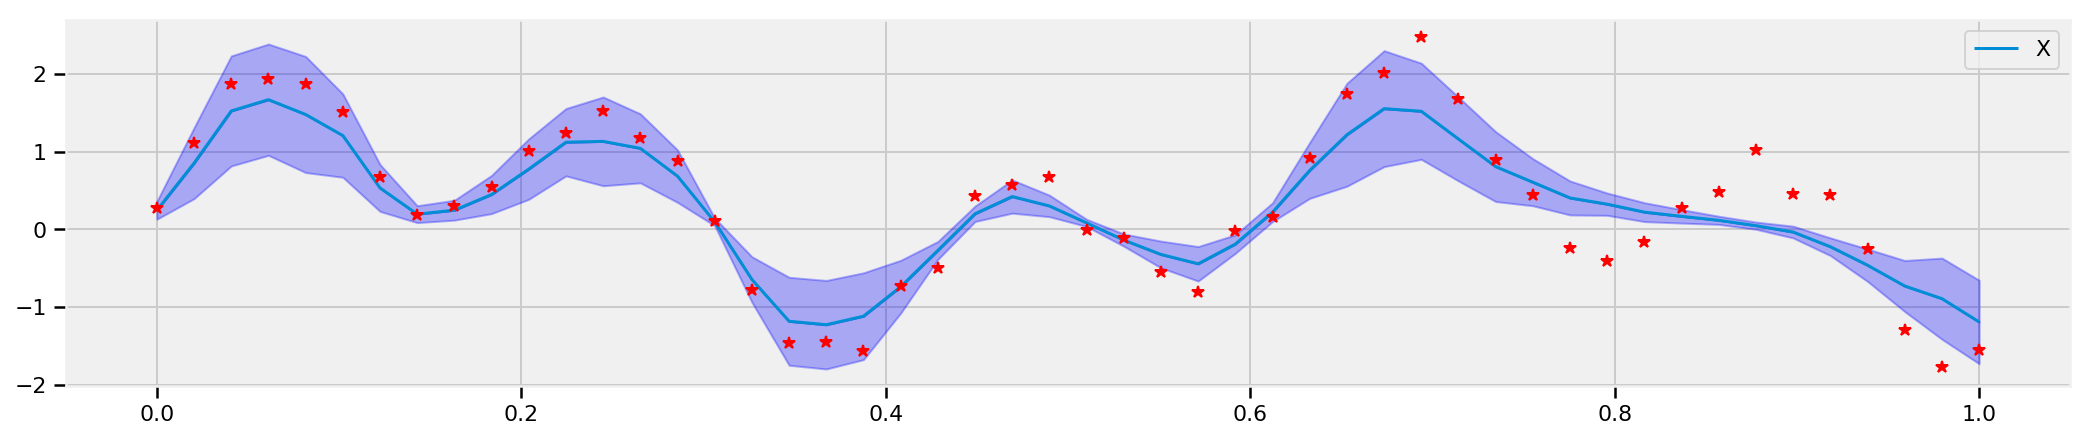

 35%|█████████████████████████████                                                      | 7/20 [00:57<01:46,  8.21s/it]

rsme is 1.2876629829406738. 
 Coverage is 0.66. 
 COBEAU is (0.22177984, 0.12164575377935978).


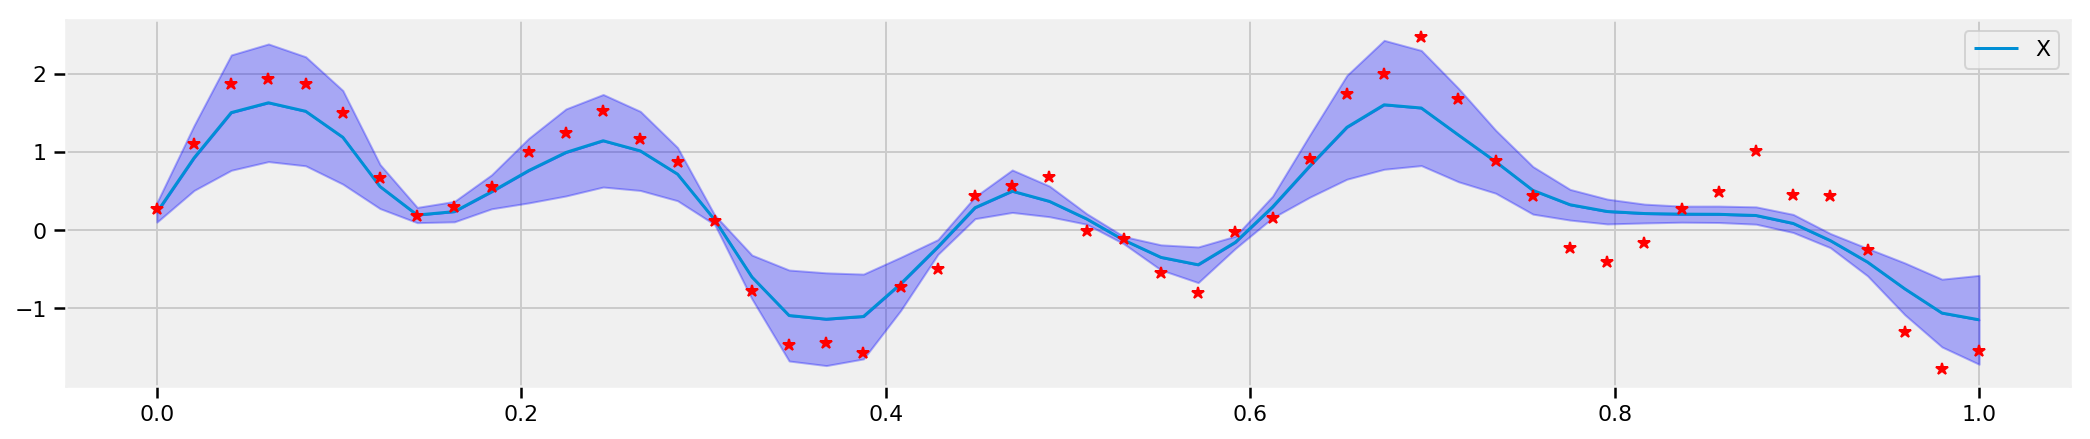

 40%|█████████████████████████████████▏                                                 | 8/20 [01:05<01:38,  8.17s/it]

rsme is 1.2932010889053345. 
 Coverage is 0.66. 
 COBEAU is (0.30738792, 0.029896444119898884).


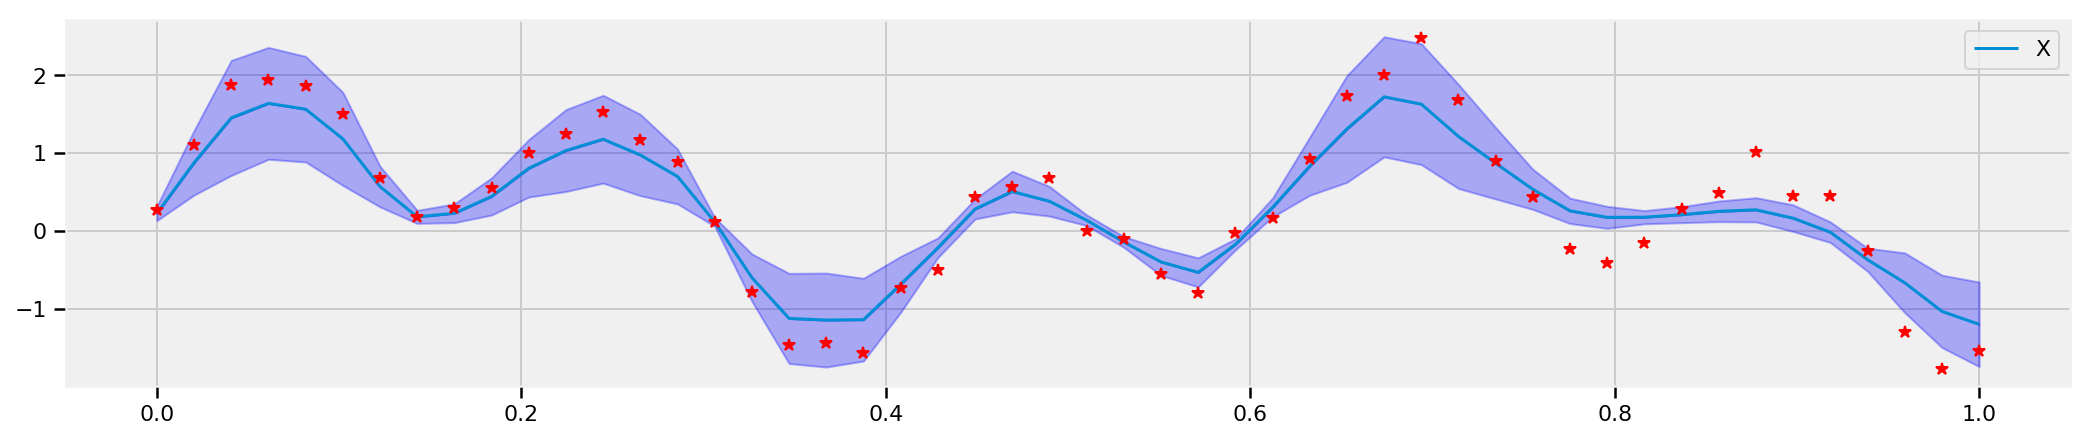

 45%|█████████████████████████████████████▎                                             | 9/20 [01:13<01:29,  8.15s/it]

rsme is 1.2941399812698364. 
 Coverage is 0.7. 
 COBEAU is (0.36118644, 0.009965722089946541).


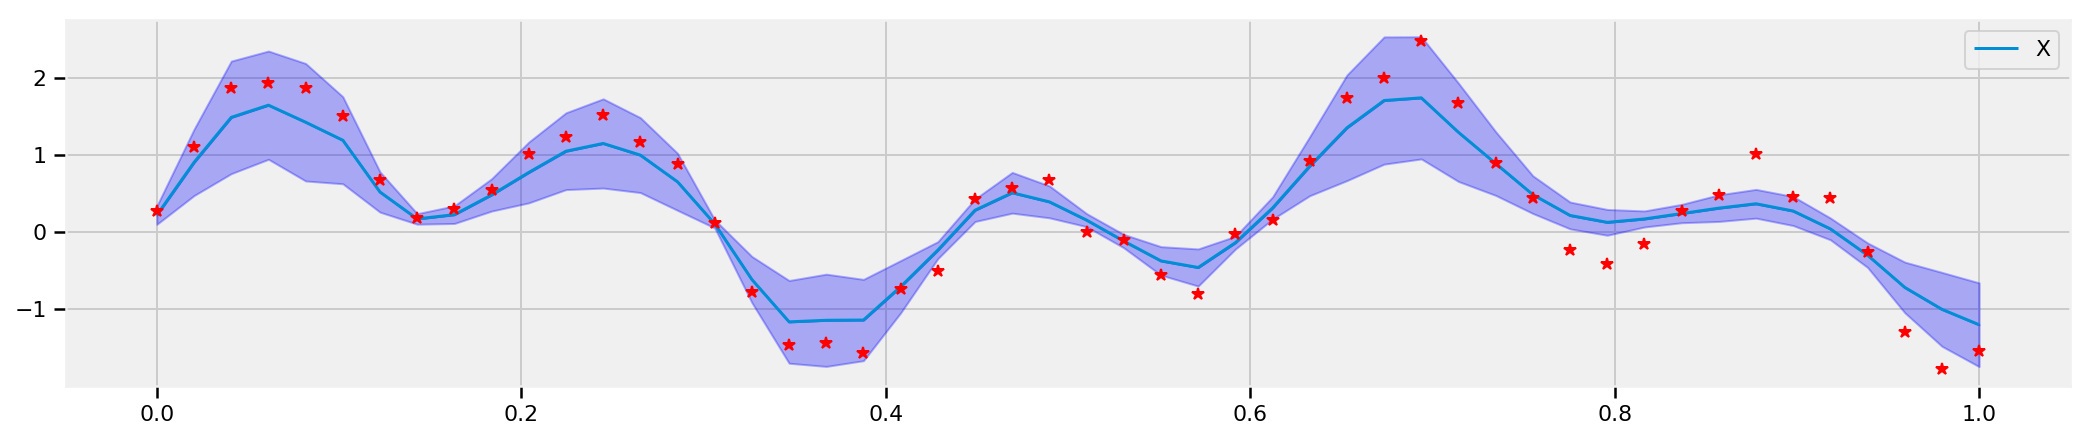

 50%|█████████████████████████████████████████                                         | 10/20 [01:21<01:21,  8.15s/it]

rsme is 1.3025397062301636. 
 Coverage is 0.76. 
 COBEAU is (0.43104953, 0.0017775869902836858).


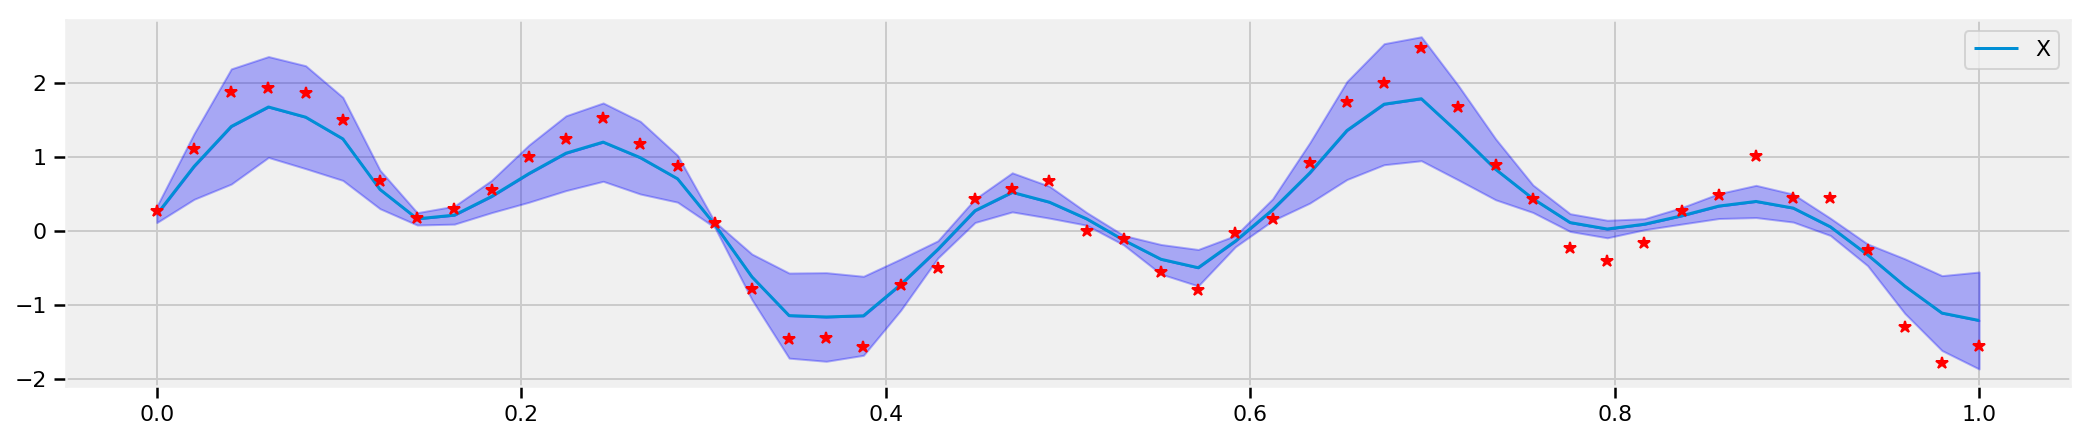

 55%|█████████████████████████████████████████████                                     | 11/20 [01:29<01:13,  8.15s/it]

rsme is 1.3023841381072998. 
 Coverage is 0.72. 
 COBEAU is (0.61281526, 2.2405541715107648e-06).


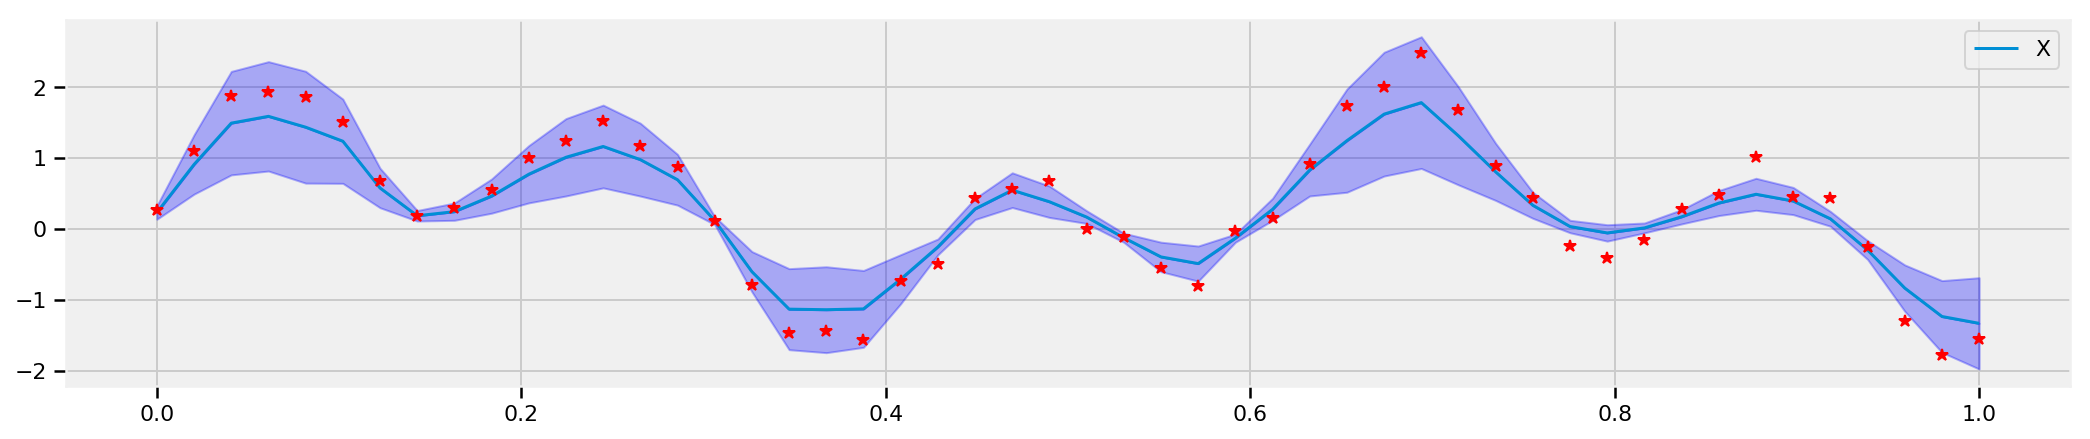

 60%|█████████████████████████████████████████████████▏                                | 12/20 [01:37<01:05,  8.19s/it]

rsme is 1.326316237449646. 
 Coverage is 0.74. 
 COBEAU is (0.64290506, 4.795492951191202e-07).


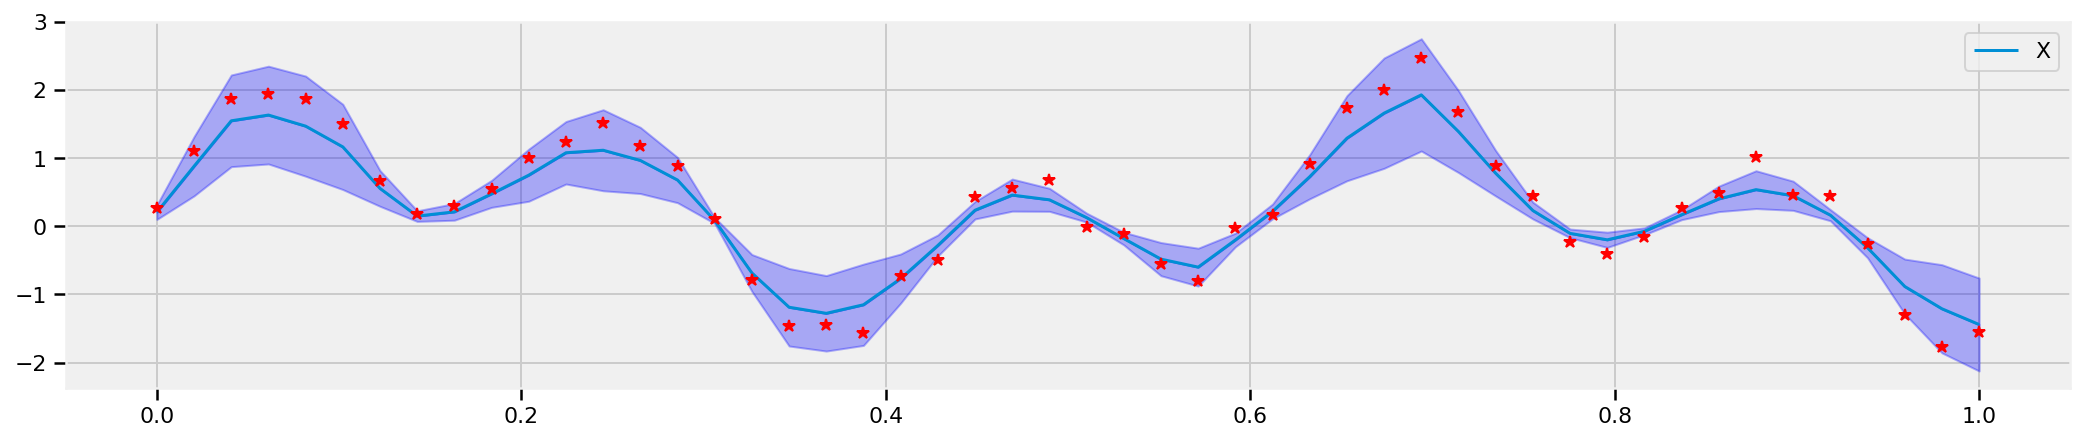

 65%|█████████████████████████████████████████████████████▎                            | 13/20 [01:46<00:57,  8.20s/it]

rsme is 1.3199615478515625. 
 Coverage is 0.78. 
 COBEAU is (0.7151546, 5.377857584395168e-09).


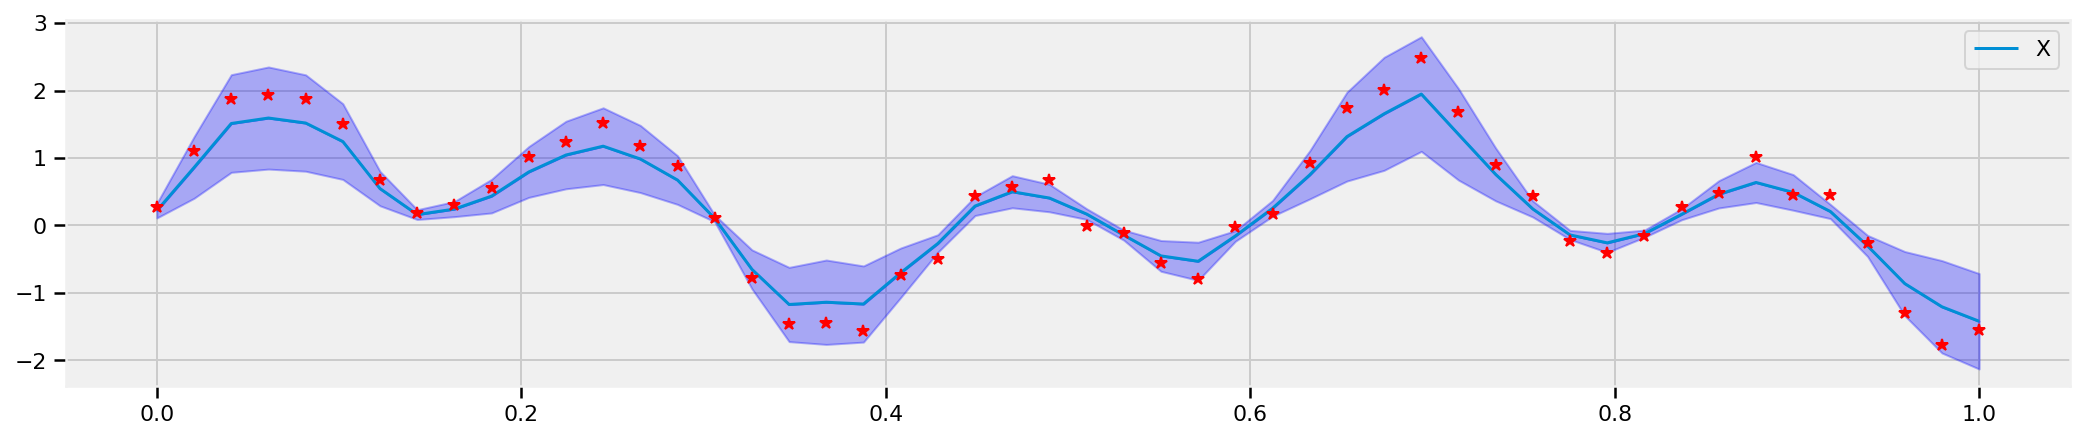

 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [01:54<00:49,  8.26s/it]

rsme is 1.3198894262313843. 
 Coverage is 0.84. 
 COBEAU is (0.74026656, 8.057776033582806e-10).


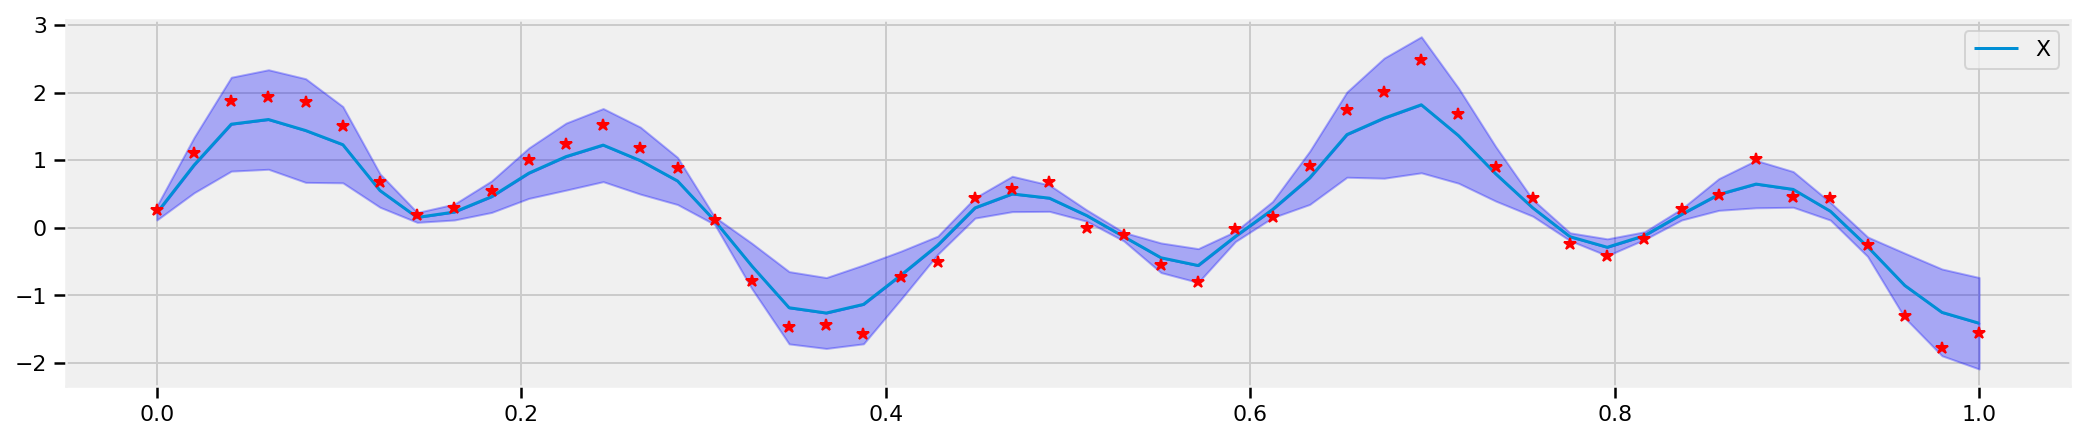

 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [02:02<00:41,  8.20s/it]

rsme is 1.3175138235092163. 
 Coverage is 0.84. 
 COBEAU is (0.73777765, 9.81894599390368e-10).


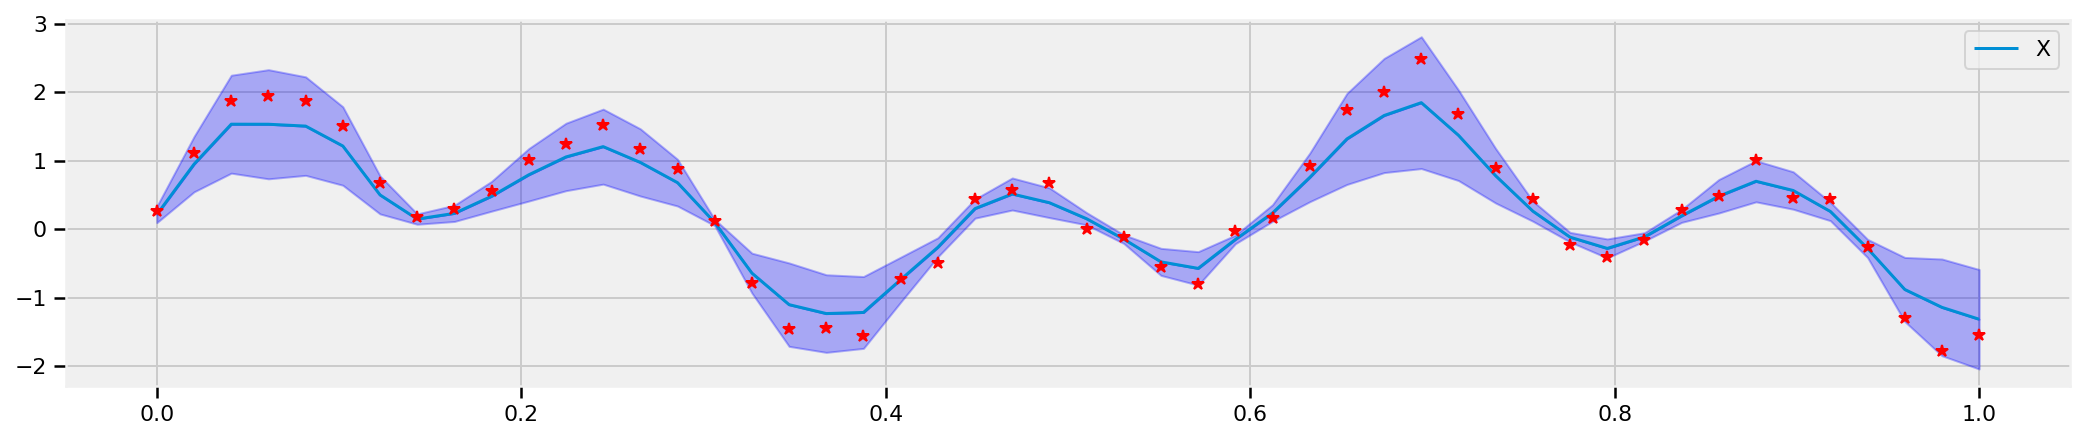

 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [02:10<00:32,  8.19s/it]

rsme is 1.320529818534851. 
 Coverage is 0.82. 
 COBEAU is (0.7830432, 1.823018353720244e-11).


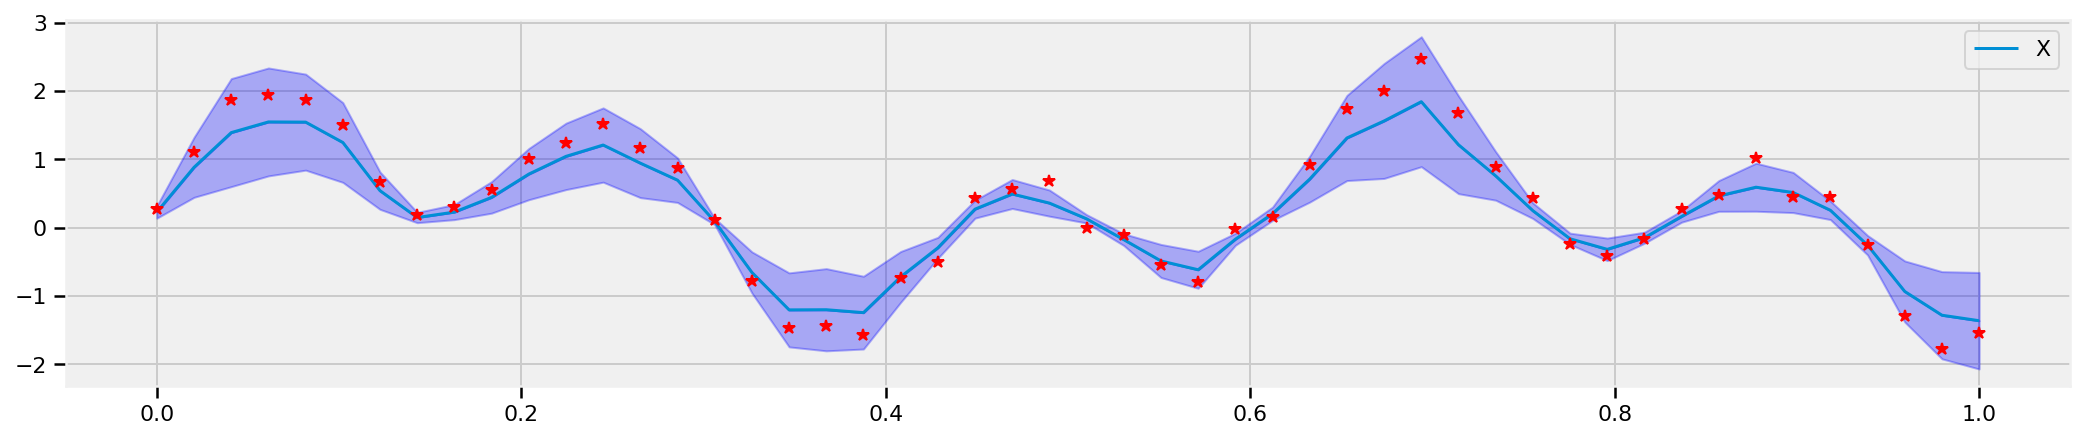

 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [02:19<00:24,  8.25s/it]

rsme is 1.3217954635620117. 
 Coverage is 0.8. 
 COBEAU is (0.826158, 1.5089496144681373e-13).


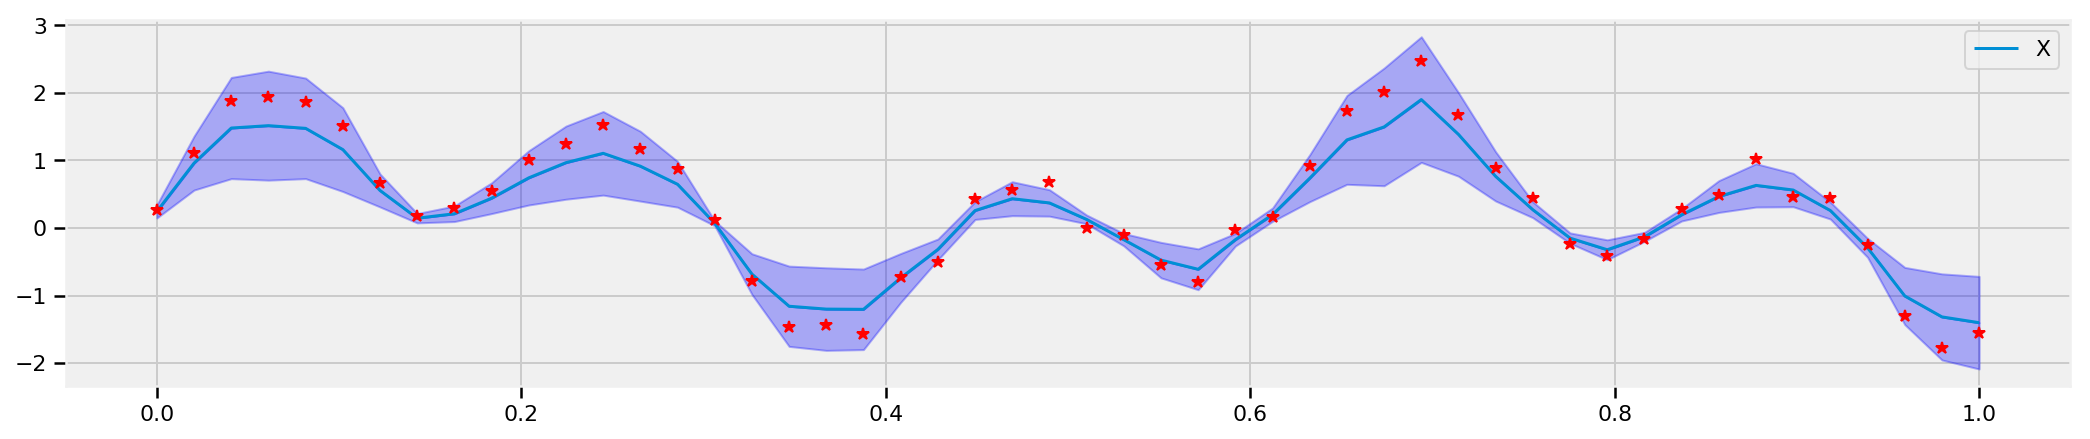

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [02:27<00:16,  8.30s/it]

rsme is 1.3244765996932983. 
 Coverage is 0.82. 
 COBEAU is (0.8164797, 4.929701865381594e-13).


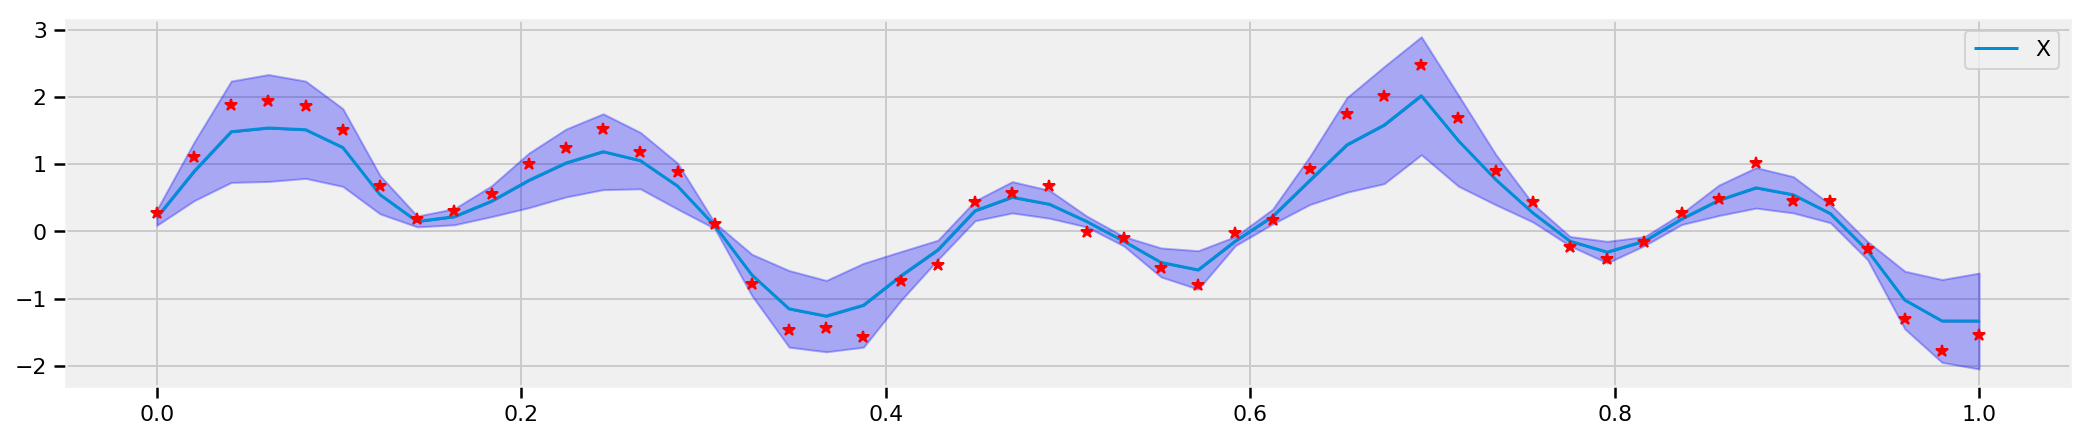

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [02:35<00:08,  8.30s/it]

rsme is 1.321946382522583. 
 Coverage is 0.84. 
 COBEAU is (0.8223303, 2.430608850920182e-13).


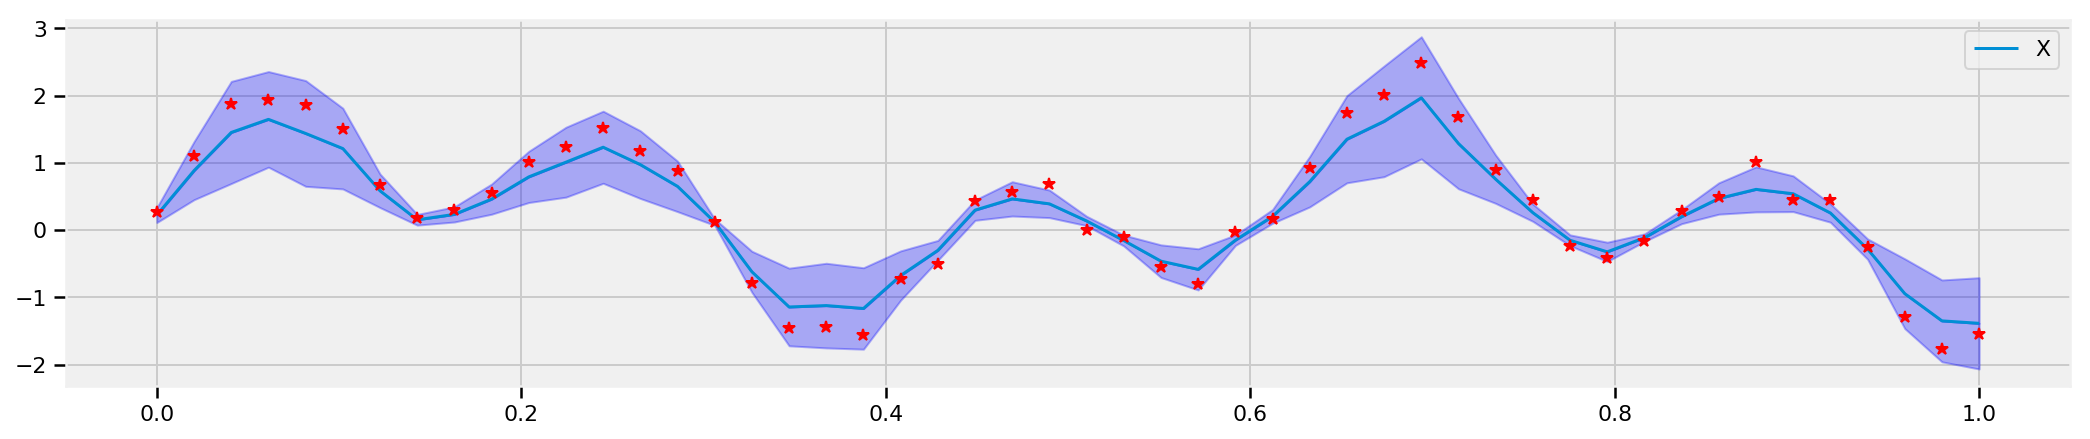

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:44<00:00,  8.24s/it]


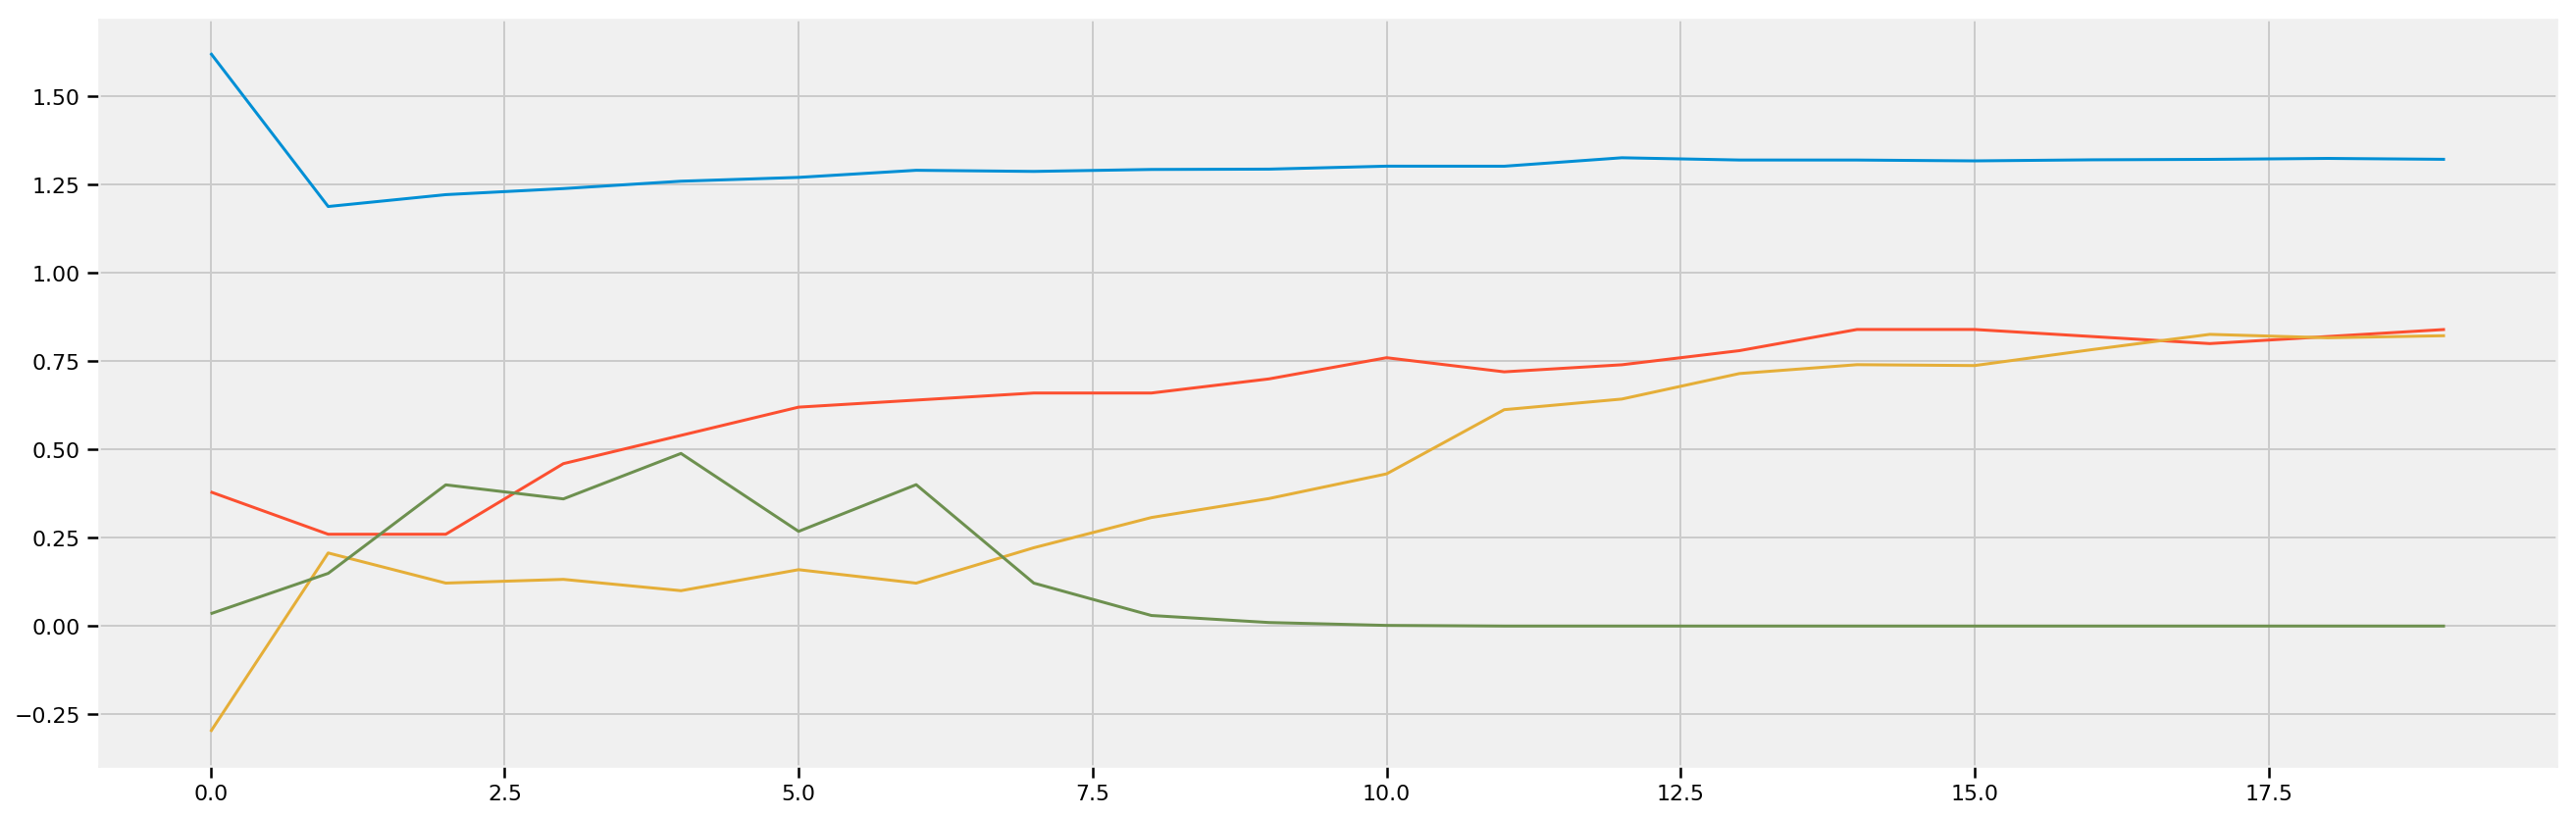

In [31]:
error_list = list()
coverage_list = list()
cobeau_list = list()

for i in tqdm.tqdm(range(meta_epochs)):


  mean, var = get_mean_var(van.predict(X))
  plt.figure(figsize = (16,8*10))

  plt.subplot(meta_epochs,1,i+1)
  plt.plot(X,mean,label='X')
  plt.plot(X,y,'r*')
  plt.fill_between(np.squeeze(X),np.squeeze(mean), np.squeeze(mean+var),alpha=0.3, color='b')
  plt.fill_between(np.squeeze(X),np.squeeze(mean), np.squeeze(mean-var),alpha=0.3, color='b')
  plt.legend()


  error = rmse(mean,y)
  coverage = coverage_probability(mean,var,y)
  cobeau = error_uncertainty_correlation(mean,var,y)
    
  error_list.append(error)
  coverage_list.append(coverage)
  cobeau_list.append(cobeau)

  print('rsme is {}. \n Coverage is {}. \n COBEAU is {}.'.format(error,coverage,cobeau))


  

  plt.show()
  a = van.fit(500)

plt.figure()
plt.plot(error_list,label='error')
plt.plot(coverage_list,label='coverage')
plt.plot(cobeau_list,label='cobeau')

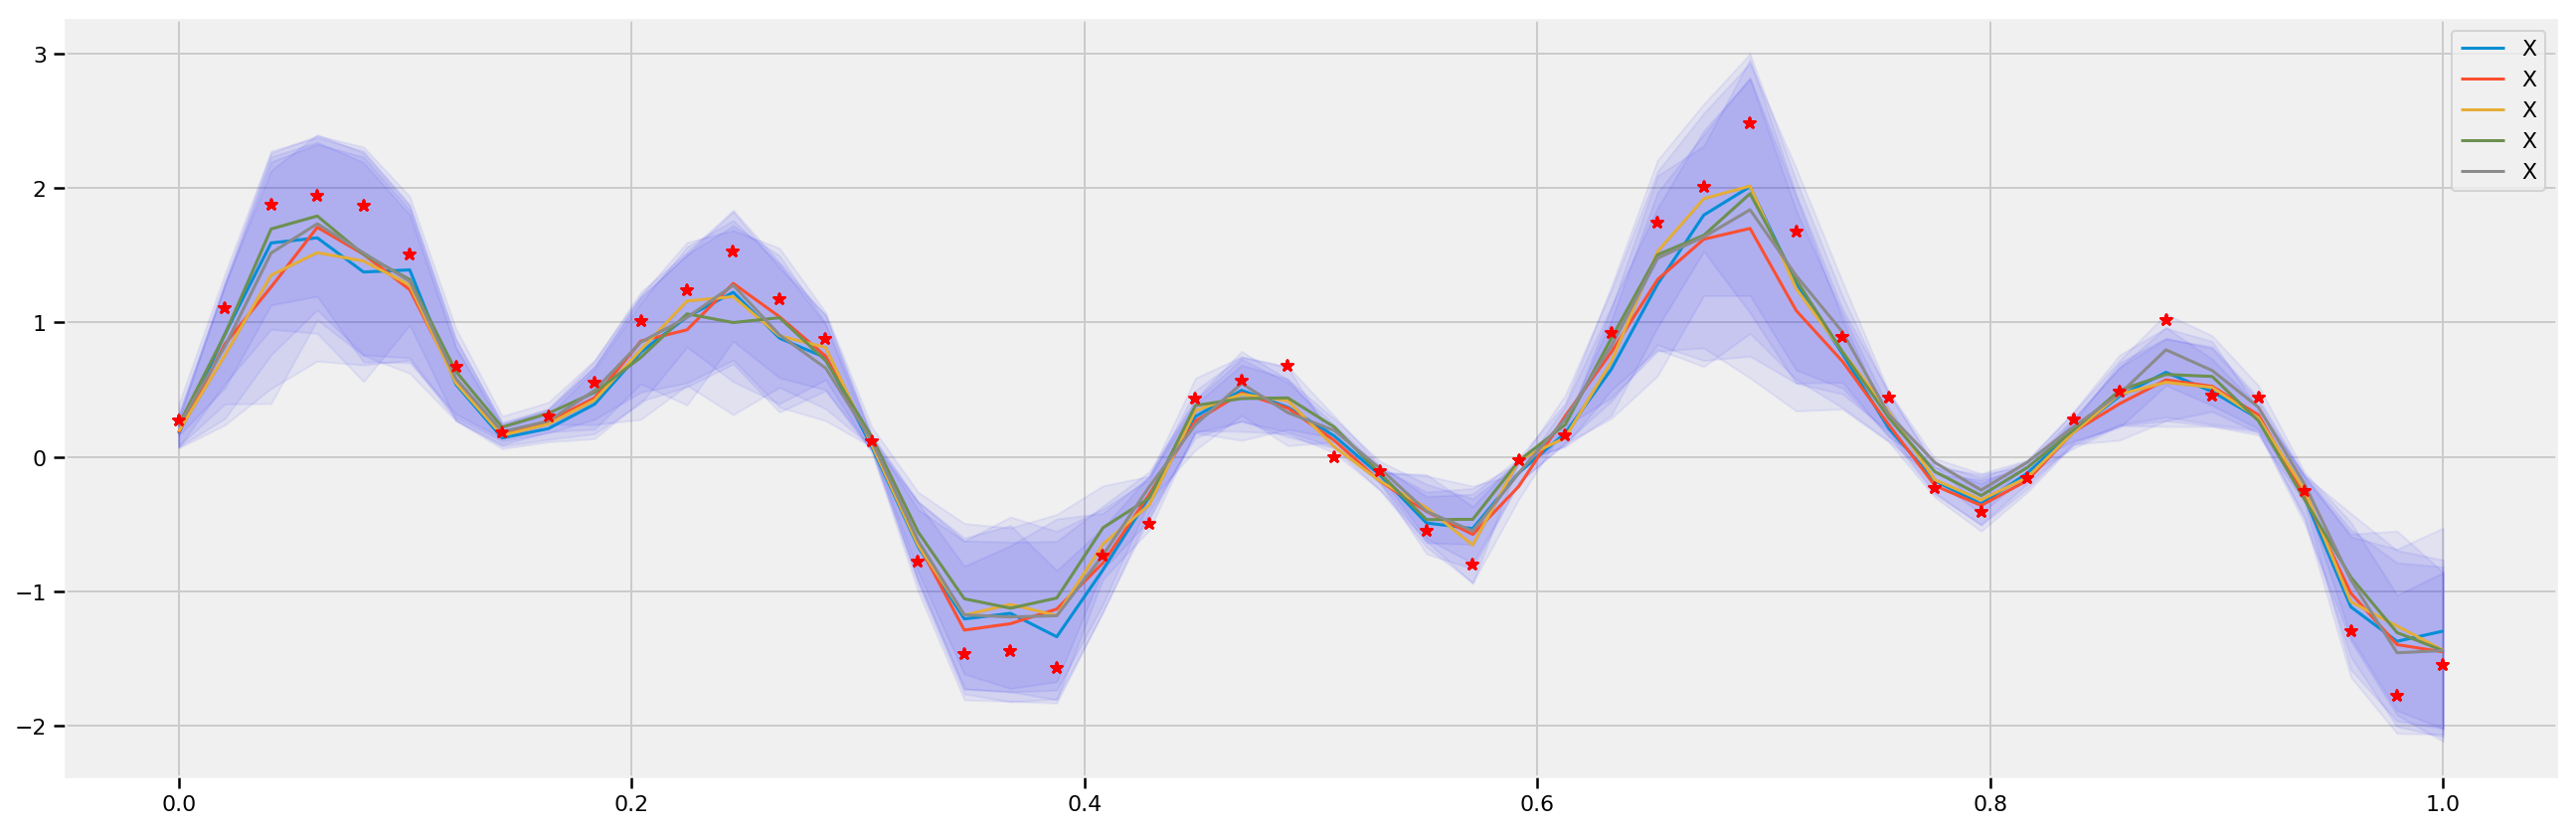

In [32]:
mean_list = list()
var_list = list()

for i in range(len(estimator_stats)):
    mean, var = get_mean_var(van.estimator_list[i].predict(X))
    mean_list.append(mean)
    var_list.append(var)
    # mean = np.mean(mean,0)
    # var = np.mean(mean)

    plt.plot(X,mean,label='X')
    plt.plot(X,y,'r*')
    plt.fill_between(np.squeeze(X),np.squeeze(mean), np.squeeze(mean+var),alpha=0.3/len(estimator_stats), color='b')
    plt.fill_between(np.squeeze(X),np.squeeze(mean), np.squeeze(mean-var),alpha=0.3/len(estimator_stats), color='b')
    plt.legend()
    


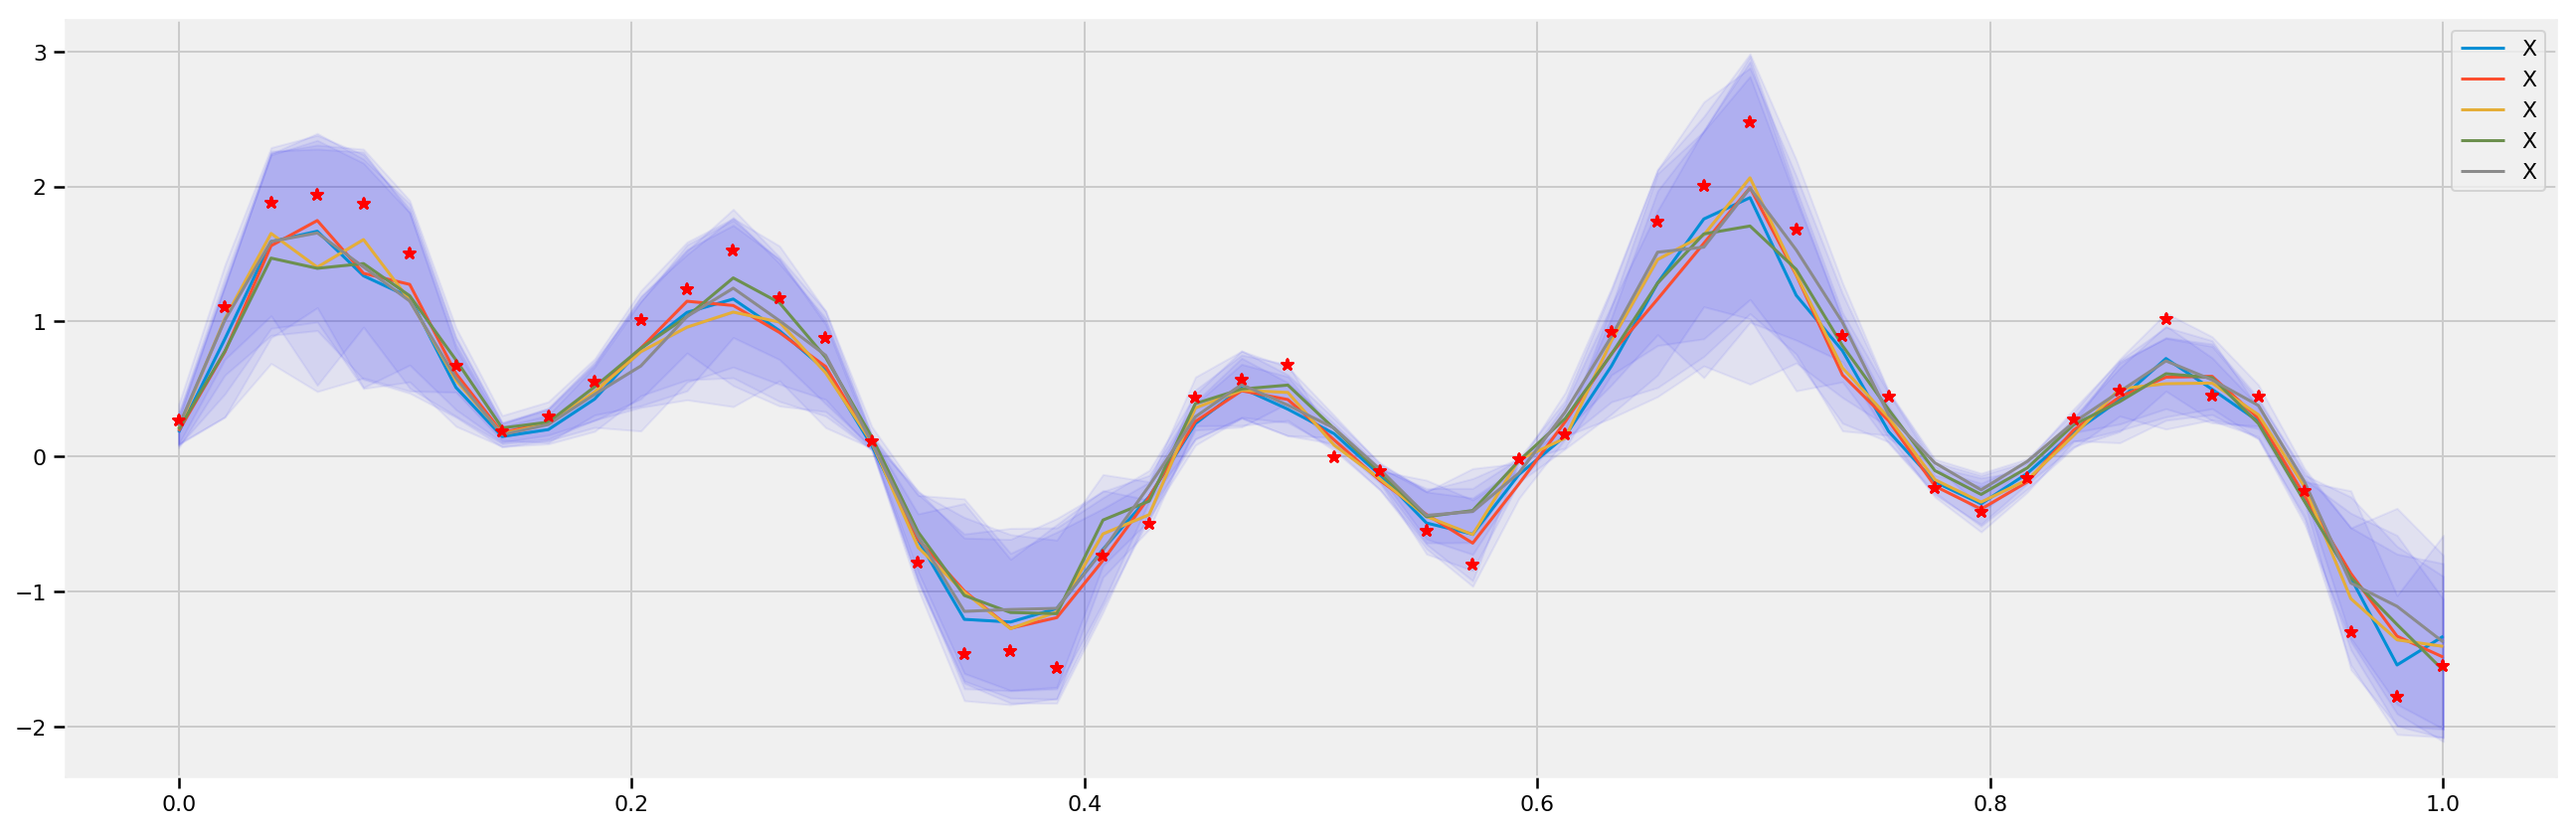

In [33]:
mean_list = list()
var_list = list()

for estimator in van.estimator_list:
    mean, var = get_mean_var(estimator.predict(X))
    mean_list.append(mean)
    var_list.append(var)
    # mean = np.mean(mean,0)
    # var = np.mean(mean)

    plt.plot(X,mean,label='X')
    plt.plot(X,y,'r*')
    plt.fill_between(np.squeeze(X),np.squeeze(mean), np.squeeze(mean+var),alpha=0.3/len(estimator_stats), color='b')
    plt.fill_between(np.squeeze(X),np.squeeze(mean), np.squeeze(mean-var),alpha=0.3/len(estimator_stats), color='b')
    plt.legend()
    


In [34]:
plt.plot(X,mean_mean+mean_var)
plt.plot(X,mean_mean-mean_var)
plt.plot(X,y,'x')

NameError: name 'mean_mean' is not defined

In [ ]:
van.estimator_list[0].num_neurons

In [ ]:
# van.plot(X,y)

Bootstrap-ish


In [ ]:
with tf.Graph().as_default() as g_1:
  dataset = tf.data.Dataset.from_tensor_slices((X, y))
  dataset = dataset.repeat()
  dataset = dataset.shuffle(100)
  dataset = dataset.batch(100)
  it = dataset.make_one_shot_iterator()
  get_next = tf.identity(it.get_next(), name = 'next')
  X_ =  tf.identity(it.get_next()[0], name="X")
  y_ =  tf.identity(it.get_next()[1], name="y")

  gdef = g_1.as_graph_def()
  
  #g_1.get_tensor_by_name('X:0')
  #g_1.get_tensor_by_name("y:0")

  #it = dataset.make_one_shot_iterator()

#X,y = it.get_next()

In [ ]:
plt.plot(nn.predict(X[10:50]))
plt.plot(y[10:50])
#plt.plot(nn.predict_meh())

In [ ]:
tf.reset_default_graph()


model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(12, input_dim=1, kernel_initializer='normal', activation='tanh'))
model.add(tf.keras.layers.Dense(8, activation='tanh'))
model.add(tf.keras.layers.Dense(1, activation='linear'))


model.compile(loss='mse', optimizer='adam', )#metrics=['mse','mae'])


model.summary()

In [ ]:
model.fit(dataset, epochs=1000, steps_per_epoch=10)

In [ ]:
plt.plot(model.predict(X)[:100])
plt.plot(y[:100])

In [ ]:
tf.reset_default_graph()


import numpy as np
import tensorflow as tf
keras = tf.keras

# tf.data.Dataset instance
tr_data = np.random.random((1000, 32)).astype(np.float32)
tr_label = np.random.randint(low=0, high=10, size = 1000).astype(np.int32)
tr_dataset = tf.data.Dataset.from_tensor_slices((tr_data, tr_label))
tr_dataset = tr_dataset.batch(batch_size=32)
tr_dataset = tr_dataset.repeat()

val_data = np.random.random((100, 32)).astype(np.float32)
val_label = np.random.randint(low=0, high=10, size = 100).astype(np.int32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_label))
val_dataset = val_dataset.batch(batch_size=100).repeat()

# Training
model = keras.Sequential()
model.add(keras.layers.Dense(units=64, activation='relu'))
model.add(keras.layers.Dense(units=64, activation='relu'))
model.add(keras.layers.Dense(units=10, activation='softmax'))
model.compile(optimizer=tf.train.GradientDescentOptimizer(.01), 
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

model.fit(tr_dataset, epochs = 5, steps_per_epoch = 1000 // 32,
          validation_data = val_dataset, validation_steps = 1)

In [ ]:
# with Session
tf.reset_default_graph()

with tf.Session() as sess:
  sess.run(predict)

In [ ]:
tf.reset_default_graph()

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((X, y))
dataset = dataset.repeat()
dataset = dataset.shuffle(1)
dataset = dataset.batch(10)

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dense(32))
model.compile(optimizer='adam', loss='mean_squared_error')
# This builds the model for the first time:


In [ ]:
model.fit(dataset.make_one_shot_iterator().get_next()[0],dataset.make_one_shot_iterator().get_next()[1], epochs=5, steps_per_epoch=10)

In [ ]:
nn.fit_dataset(X,y)

In [ ]:
import tensorflow as tf
import numpy as np

class Network:
    def __init__(self, x_in, input_size):
        self.input_size = input_size
        # self.x_in = tf.placeholder(dtype=tf.float32, shape=(None, self.input_size))  # Original
        self.x_in = x_in
        self.output_size = 3

        #tf.reset_default_graph()  # This turned out to be the problem

        self.layer = tf.layers.dense(self.x_in, self.output_size, activation=tf.nn.relu)
        self.loss = tf.reduce_sum(tf.square(self.layer - tf.constant(0, dtype=tf.float32, shape=[self.output_size])))

data_array = np.random.standard_normal([4, 10]).astype(np.float32)
dataset = tf.data.Dataset.from_tensor_slices(data_array).batch(2)

model = Network(x_in=dataset.make_one_shot_iterator().get_next(), input_size=dataset.output_shapes[-1])

NEW


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn import datasets

# 推論

def inference(x):
    with tf.name_scope('l1') as scope:
        w_l1 = tf.Variable(tf.truncated_normal(
            [10, 256], stddev=0.33), name="w_l1")
        b_l1 = tf.Variable(tf.constant(1.0, shape=[256]), name="b_l1")
        h_l1 = tf.nn.relu(tf.matmul(x, w_l1) + b_l1)

    with tf.name_scope('l2') as scope:
        w_l2 = tf.Variable(tf.truncated_normal(
            [256, 1], stddev=0.33), name="w_l2")
        b_l2 = tf.Variable(tf.constant(1.0, shape=[1]), name="b_l2")
        output = tf.nn.relu(tf.matmul(h_l1, w_l2) + b_l2)

    return output

# 損失関数
def loss(model, y):
    return tf.reduce_mean(tf.square(model - y), name="loss")

# 学習
def training(loss, rate):
    return tf.train.AdagradOptimizer(rate).minimize(loss)

def main():
    diabetes = datasets.load_diabetes()
    data = diabetes["data"].astype(np.float32)
    target = diabetes['target'].astype(
        np.float32).reshape(len(diabetes['target']), 1)

    MAX_SIZE = data.shape[0]
    TEST_N = 100
    N = MAX_SIZE - TEST_N
    BATCH_SIZE = 10
    MAX_STEPS = 300

    train_x, test_x = np.vsplit(data, [N])
    train_y, test_y = np.vsplit(target, [N])

    # symbolic variables
    x = tf.placeholder(tf.float32, shape=[None, 10])
    y = tf.placeholder(tf.float32, shape=[None, 1])

    model = inference(x)
    loss_value = loss(model, y)
    train_op = training(loss_value, 0.04)

    best = float("inf")
    init_op = tf.global_variables_initializer()

    with tf.Session() as sess:
        sess.run(init_op)
        for step in range(MAX_STEPS + 1):
            for i in range(N // BATCH_SIZE):
                batch = BATCH_SIZE * i
                train_batch_x = train_x[batch:batch + BATCH_SIZE]
                train_batch_y = train_y[batch:batch + BATCH_SIZE]

                loss_train = sess.run(loss_value, feed_dict={
                                      x: train_batch_x, y: train_batch_y})
                sess.run(train_op, feed_dict={
                         x: train_batch_x, y: train_batch_y})

            if loss_train < best:
                best = loss_train
                best_match = sess.run(model, feed_dict={x: test_x, y: test_y})

            if step % 10 == 0:
                cor = np.corrcoef(best_match.flatten(), test_y.flatten())
                print('step : {}, train loss : {}, test cor : {}'.format(
                    step, best, cor[0][1]))

In [ ]:
main()